
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Cristóbal Álvarez Contreras

**Rol**: 201710504-6

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [137]:
import numpy as np #Algebra lineal numerica
import pandas as pd #Manipulacion de datos
from sklearn import datasets #modulo de librerias
import matplotlib.pyplot as plt #Graficos
import seaborn as sns #Graficos 
from sklearn.model_selection import train_test_split #Dividir datos
#----------------------------------------------------------------------------
#Librerias de modelos
from sklearn.linear_model import LogisticRegression #Regresor logistico
from sklearn.svm import SVC #SVM para clasificación
from sklearn.tree import DecisionTreeClassifier #Arbol de decisión
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
#----------------------------------------------------------------------------
from sklearn.model_selection import GridSearchCV #Estimador de parametros
from metrics_classification import summary_metrics #Resumen de métricas en archivo .py
from sklearn.metrics import confusion_matrix #Matriz de confusión
from sklearn.metrics import plot_confusion_matrix#Grafico de matriz de confusion
from time import time #importamos la función time para capturar tiempos
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import validation_curve


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

Veamos las dimensiones del dataset y que valores posibles asume la columna target

In [6]:
print("Hay",len(digits["target"].unique()),"valores posibles para la variable target")
print(digits["target"].unique())

print("Las dimensiones de los datos son:")
print(digits.shape)

Hay 10 valores posibles para la variable target
[0 1 2 3 4 5 6 7 8 9]
Las dimensiones de los datos son:
(1797, 65)


Podemos hacer un grafico de frecuencias para la columna target para notar si hay desbalance en las clases

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

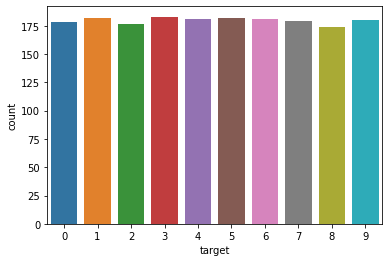

In [7]:
sns.countplot(digits["target"])

Podemos observar que las clases están balanceadas por lo que no habrá pérdida de generalización por parte del algoritmo de Machine Learning que usaremos, esto pues al existir un desbalance en las clases el algoritmo tiende a preferir las clases mayoritarias.

Tambien podemos notar que no hay valores perdidos pues existen 65 valores posibles que toman el valor False cuando se consulta sobre su igualdad a un valor nulo

In [8]:
digits.isnull().any().describe()

count        65
unique        1
top       False
freq         65
dtype: object

Tambien podemos observar estadísticas generales sobre los datos

In [9]:
digits.describe() #Estadisticas por columna

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


El tipo de datos presente son solo variables numéricas, esto se puede observar llamando al comando `.info()` que además nos entrega el uso de memoria

In [10]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c00     1797 non-null   int32
 1   c01     1797 non-null   int32
 2   c02     1797 non-null   int32
 3   c03     1797 non-null   int32
 4   c04     1797 non-null   int32
 5   c05     1797 non-null   int32
 6   c06     1797 non-null   int32
 7   c07     1797 non-null   int32
 8   c08     1797 non-null   int32
 9   c09     1797 non-null   int32
 10  c10     1797 non-null   int32
 11  c11     1797 non-null   int32
 12  c12     1797 non-null   int32
 13  c13     1797 non-null   int32
 14  c14     1797 non-null   int32
 15  c15     1797 non-null   int32
 16  c16     1797 non-null   int32
 17  c17     1797 non-null   int32
 18  c18     1797 non-null   int32
 19  c19     1797 non-null   int32
 20  c20     1797 non-null   int32
 21  c21     1797 non-null   int32
 22  c22     1797 non-null   int32
 23  c23     1797 

Para visualizar la distribución de los datos usamos `distplot`, con esto hay ciertas variables que poseen un solo valor, como por ejemplo c00 mientras que otras se puede realizar una estimación por kernels de la distribución de probabilidad debido a que poseen varianza 

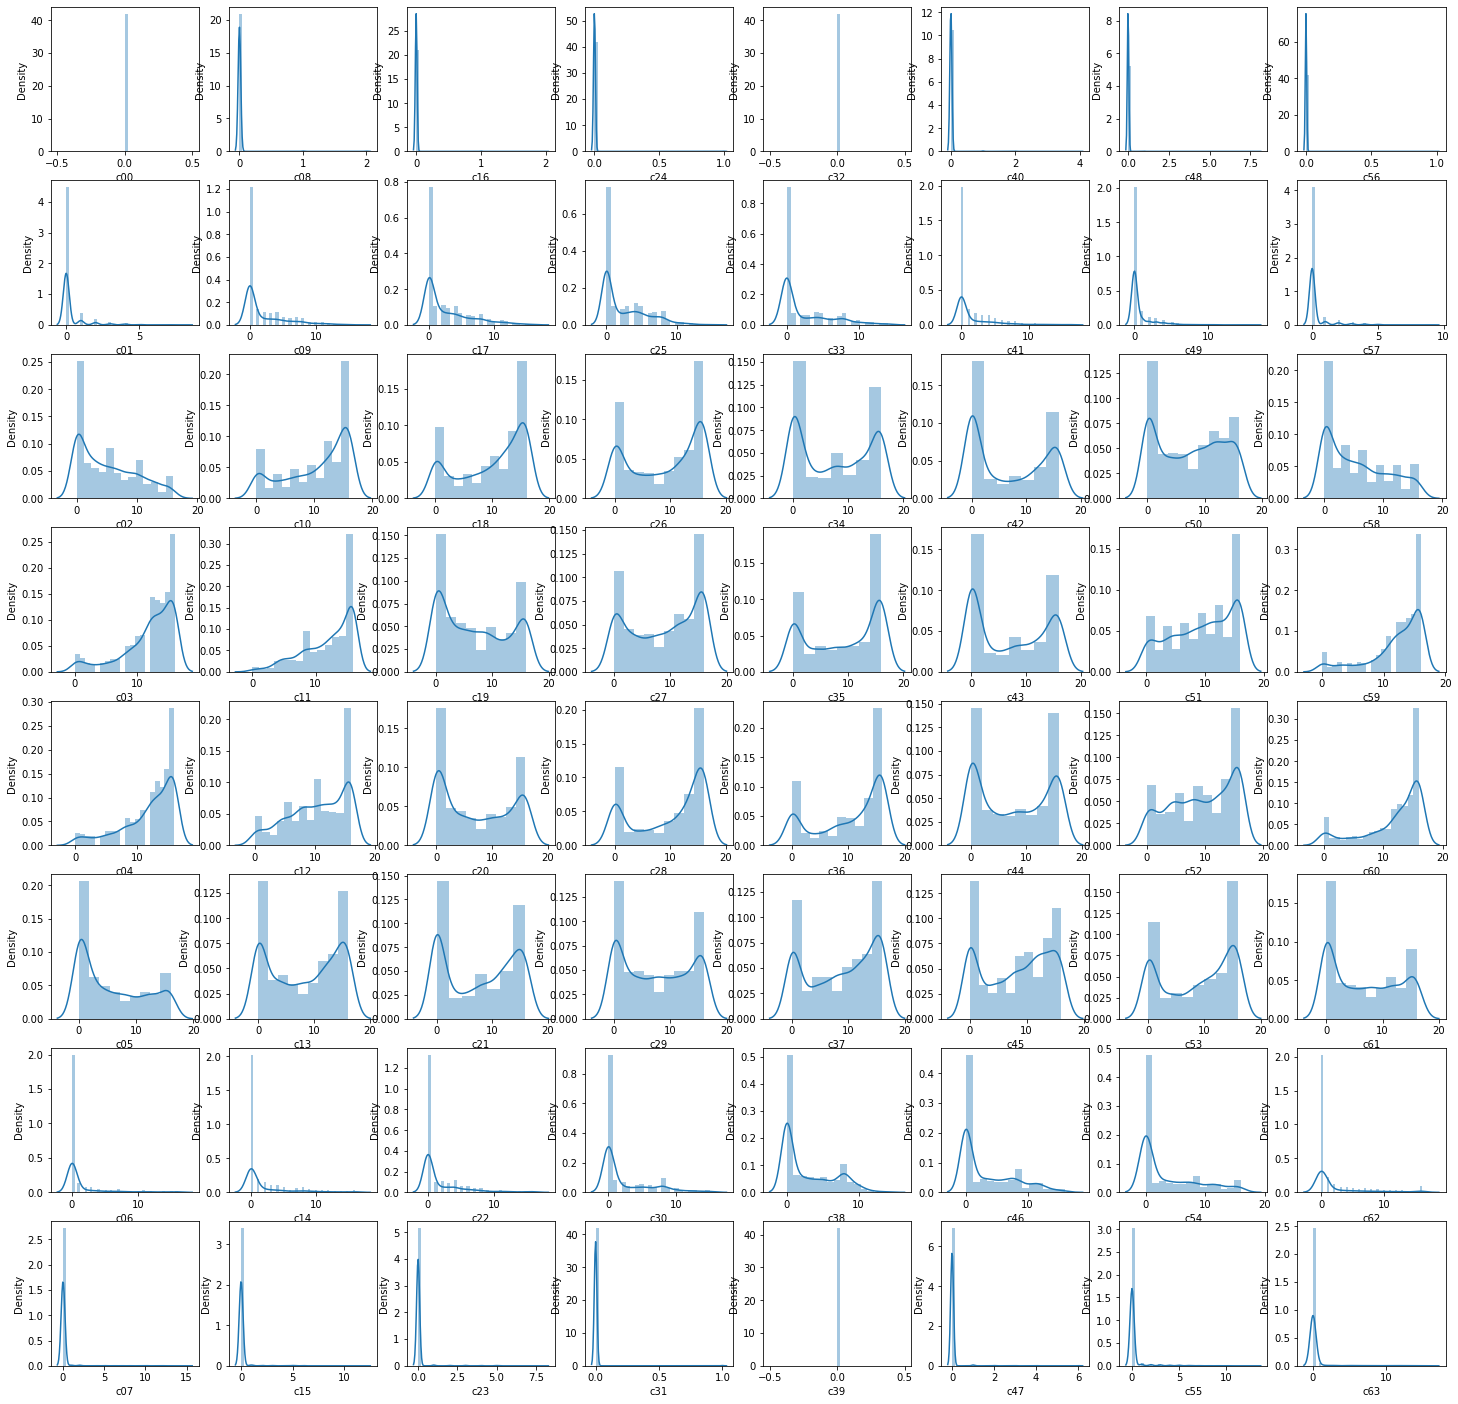

In [11]:
import warnings
warnings.filterwarnings("ignore")

nx,ny = 8,8
columnas = digits.columns
i=0
fig, axs = plt.subplots(nx, ny, figsize=(25, 25))
for y in range(ny):
    for x in range(nx):
        sns.distplot(digits[columnas[i]], hist=True, rug=False, ax=axs[x,y],label = columnas[i])
        i+=1

Vemos que muchas variables tienen un sesgo a valer 0 en todas partes o poseen baja varianza por lo que en nuestra fase de selección de atributos debemos analizar el efecto de removerlas.

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [12]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

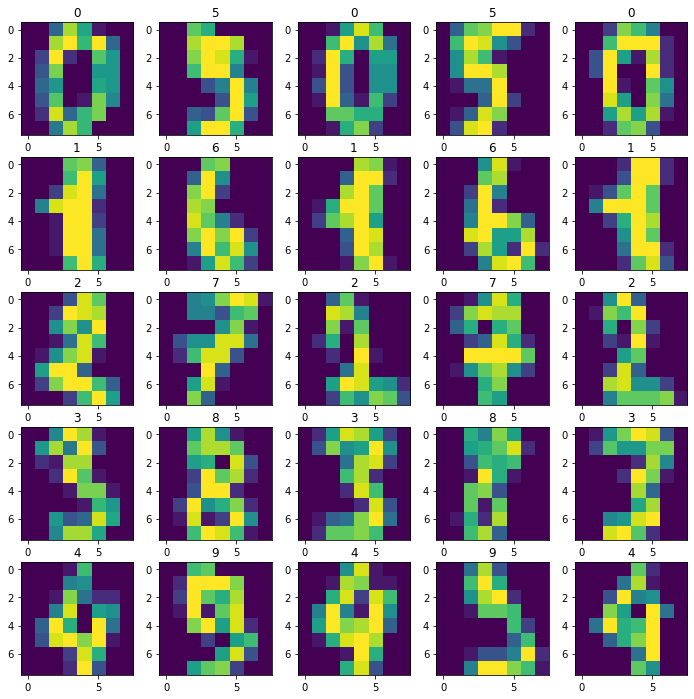

In [13]:
nx, ny = 5, 5
i=0
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for y in range(ny):#Recorrer en eje y
    for x in range(nx): #Recorrer en eje x
        axs[x,y].imshow(digits_dict["images"][i]) #Mostrar la imagen i esima 
        axs[x,y].set_title(digits_dict["target"][i]) #Titulo de la imagen 
        i+=1#Actualizar contador

Para identificar mejor las imagenes las veremos en una escala de grises

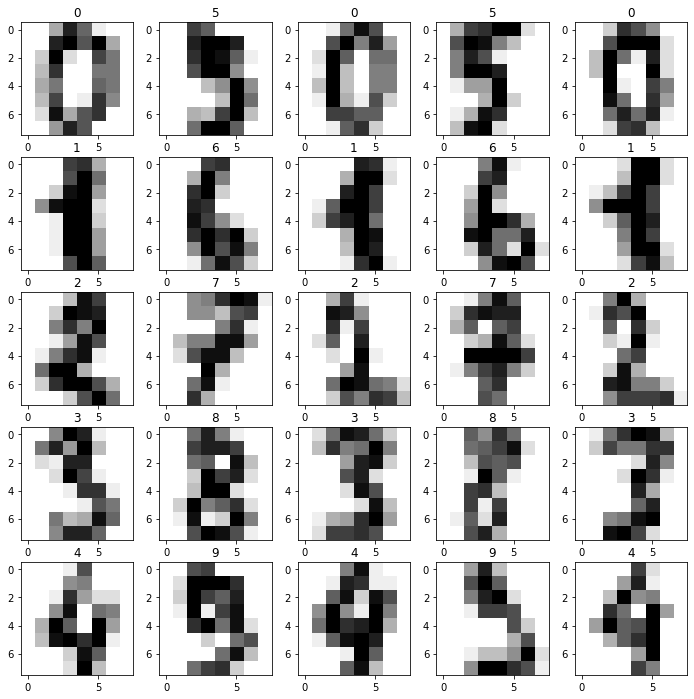

In [14]:
nx, ny = 5, 5
i=0
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for y in range(ny):
    for x in range(nx):
        axs[x,y].imshow(digits_dict["images"][i], cmap = "binary") #Identico al anterior solo que se agrega un mapa de colores binario
        axs[x,y].set_title(digits_dict["target"][i])
        i+=1

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [15]:
X = digits.drop(columns="target").values
y = digits["target"].values



Como existen 1797 filas considerando la regla empirica adoptada en el curso vamos a considerar 80% de los datos como entrenamiento y 20% para test

In [16]:
#train - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360


Dado que el problema quiere predecir una categoria se tendrá un problema de clasificación en el contexto de aprendizaje supervisado, ante esto disponemos de 4 modelos de clasificación los cuales son
* Regresor logístico
* SVM 
* Árboles de decisión
* Random Forest

Vamos a probar cada uno de estos en el conjunto de entrenamiento para tener una estimación del error y aquel que posean mejores resultados será probado en el conjunto de test

En el caso del regresor logistico adoptaremos por defecto un penalty `l1` pues este último está especializado para problemas con matrices sparse, en este caso la matriz con los datos posee muchos cero y de hecho vimos en la parte anterior que muchas variables solo asumen el valor 0

In [17]:
#Nombres de modelos
names = ["Logistic",
         "RBF SVM", 
         "Decision Tree", 
         "Random Forest",
         "KNN"
]

#Modelos
classifiers = [
    LogisticRegression(penalty = "l1",solver = "saga",tol=0.01),
    SVC(kernel = "rbf"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]

#Lista con grid de parametros para estimar los valores óptimos, respetan el mismo orden que classifiers
list_param_grid = [
    #Regresor logistico: 
    {
        "C": [1,2,3,4,5], #Parametro de regularización
    },
    #SVM:
    {
        "C":[0.5,1,2,3,4,5], #Parametro de regularización
    },
    #Arbol de decisión:
    {
        "criterion": ["gini","entropy"], 
        "min_samples_split":[0.5,2,4,10,30,50],
        "min_samples_leaf":[1,2,5,10],
        "min_weight_fraction_leaf":[0.01,0.05,0.1,0.5],
        "max_features":["auto", "sqrt", "log2"]
    },
    #Random Forest
    {
        "n_estimators":[50,100,150,200,300,400],
        "criterion":["gini", "entropy"],
        "max_depth": [1,5,10,100,150]
    },
    #KNN 
    {
        "n_neighbors":[3,5,7,10,15,20,30],
        "leaf_size":[10,20,30,40,50],
        "p":[1,2,3,4,5],
    }
]

Iteramos por cada modelo, encontrando sus parámetros óptimos, predicciones, matriz de confusión y tiempos de ejecución:

------------------------------------------------------------------------------------------
Logistic
Parametros óptimos:
{'C': 3}
El tiempo de ejecucion en la fase de estimación de parámetros fue: 7.142565488815308 [s]

El tiempo de ejecucion en la fase de entrenamiento fue: 0.2782602310180664 [s]

Precisión: 0.975

Matriz de confusion:
 


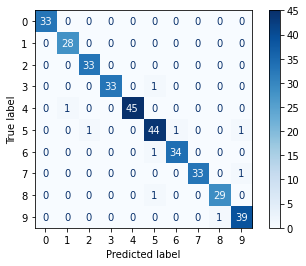

------------------------------------------------------------------------------------------
RBF SVM
Parametros óptimos:
{'C': 5}
El tiempo de ejecucion en la fase de estimación de parámetros fue: 1.907074213027954 [s]

El tiempo de ejecucion en la fase de entrenamiento fue: 0.06180143356323242 [s]

Precisión: 0.989

Matriz de confusion:
 


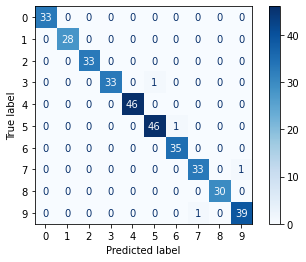

------------------------------------------------------------------------------------------
Decision Tree
Parametros óptimos:
{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.01}
El tiempo de ejecucion en la fase de estimación de parámetros fue: 5.3845648765563965 [s]

El tiempo de ejecucion en la fase de entrenamiento fue: 0.002977132797241211 [s]

Precisión: 0.686

Matriz de confusion:
 


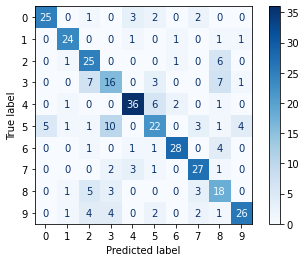

------------------------------------------------------------------------------------------
Random Forest
Parametros óptimos:
{'criterion': 'gini', 'max_depth': 100, 'n_estimators': 400}
El tiempo de ejecucion en la fase de estimación de parámetros fue: 144.40255856513977 [s]

El tiempo de ejecucion en la fase de entrenamiento fue: 1.059844732284546 [s]

Precisión: 0.972

Matriz de confusion:
 


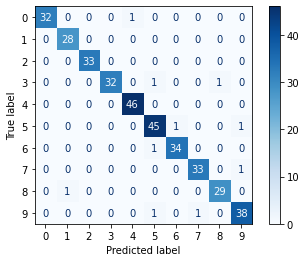

------------------------------------------------------------------------------------------
KNN
Parametros óptimos:
{'leaf_size': 10, 'n_neighbors': 3, 'p': 3}
El tiempo de ejecucion en la fase de estimación de parámetros fue: 246.70955395698547 [s]

El tiempo de ejecucion en la fase de entrenamiento fue: 0.023908615112304688 [s]

Precisión: 0.983

Matriz de confusion:
 


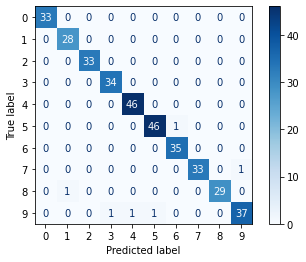

In [18]:
#modelos
frames = [] #lista con los frames que contendran las metricas
for i in range(len(classifiers)): 
    print("------------------------------------------------------------------------------------------")
    #definir modelo
    model = classifiers[i]
    name = names[i]
    param_grid =list_param_grid[i]
    print(name)
    
    #Estimacion de parametros
    print("Parametros óptimos:")
    tiempo_inicial_1 = time() 
    
    gs = GridSearchCV(estimator=model, 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      cv=5,
                      n_jobs=1)
    gs = gs.fit(X_train, y_train)
    print(gs.best_params_)
    
    tiempo_final_1 = time() 
    tiempo_ejecucion_1 = tiempo_final_1 - tiempo_inicial_1
    
    print("El tiempo de ejecucion en la fase de estimación de parámetros fue:",tiempo_ejecucion_1,"[s]\n") 
    
    mejor_modelo = gs.best_estimator_
    
    
    #Ajuste del mejor modelo
    tiempo_inicial = time() 
    mejor_modelo.fit(X_train, y_train)
    tiempo_final = time() 
    tiempo_ejecucion = tiempo_final - tiempo_inicial 
    
    print("El tiempo de ejecucion en la fase de entrenamiento fue:",tiempo_ejecucion,"[s]\n") 
    print('Precisión: {0:.3f}'.format(mejor_modelo.score(X_test, y_test)))
    
    y_data=pd.DataFrame(data = y_test, columns =["y"])
    yhat = pd.DataFrame(data = gs.predict(X_test),columns = ["yhat"])
    
    print('\nMatriz de confusion:\n ')
    
    plot_confusion_matrix(mejor_modelo, X_test, y_test,
                             display_labels=digits_dict.target_names,
                             cmap=plt.cm.Blues)
    plt.show()
    resumen = pd.concat([y_data,yhat],axis=1)
    resultados = summary_metrics(resumen)
    frames.append(resultados)


In [19]:
#Métricas
scores = pd.concat(frames)
scores["Modelo"] = names
scores

,accuracy,recall,precision,fscore,Modelo
0,0.9750,0.9769,0.9762,0.9764,Logistic
0,0.9889,0.9895,0.9897,0.9895,RBF SVM
0,0.6861,0.6938,0.6966,0.6906,Decision Tree
0,0.9722,0.9727,0.9740,0.9732,Random Forest
0,0.9833,0.9841,0.9840,0.9839,KNN


Vemos que en términos de rendimiento con scores y además considerando el tiempo de entrenamiento el modelo de SVC (support vector classification) obtiene mejores resultados que los demás modelos y además su tiempo de entrenamiento es mucho mejor pues ni siquiera pasa los 5 segundos.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

## Cross Validation

In [20]:
model = SVC(kernel = "rbf", C = 5)
scores = cross_val_score(model, X, y, cv=10)
print("Accuracy : %0.2f\nStandard deviation: %0.2f" % (scores.mean(), scores.std()))

Accuracy : 0.98
Standard deviation: 0.02


Por lo tanto nuestro intervalo de confianza será 0.98$\pm$ 0.02.

## Curva de validación

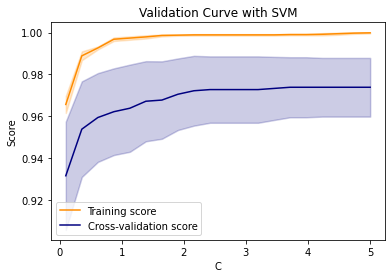

In [21]:
param_range = np.linspace(0.1, 5,20)

train_scores, test_scores = validation_curve(
    SVC(kernel  ="rbf",C=5), X, y, param_name="C", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
#plt.ylim(0.90, 1.0)
lw = 1.5
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)

plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)

plt.legend(loc="best")
plt.show()


Podemos notar que la diferencia entre el accuracy de entrenamiento y el de validación es pequeña por lo que nuestro modelo tiende a ajustarse de buena manera en conjuntos de testeo.

## Curva AUC - ROC

In [25]:
y = label_binarize(y, classes=[0 , 1 , 2 , 3 , 4 , 6 , 7 , 8 , 9])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.2,
                                                    random_state=42)
classifier = OneVsRestClassifier(SVC(kernel='rbf', probability=True,
                                 random_state=42,C=5))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i],_= roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


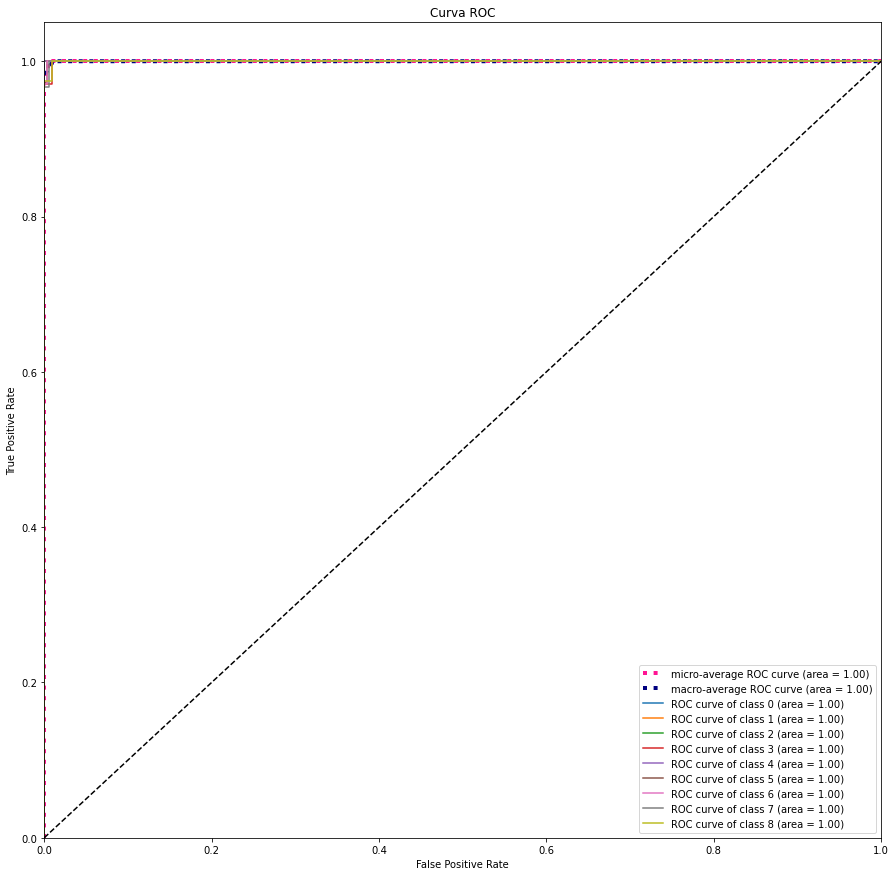

In [26]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (15,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Podemos notar que la probabilidad de acierto es 1 en todos los casos por lo que nuestro clasificador discrimina de buena manera las diferentes clases.

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


## 5.1. Selección de atributos

In [29]:
digits

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0,0,4,10,13,6,0,0,0,1,...,0,0,0,2,14,15,9,0,0,9
1793,0,0,6,16,13,11,1,0,0,0,...,0,0,0,6,16,14,6,0,0,0
1794,0,0,1,11,15,1,0,0,0,0,...,0,0,0,2,9,13,6,0,0,8
1795,0,0,2,10,7,0,0,0,0,0,...,0,0,0,5,12,16,12,0,0,9


Mediante el análisis realizado al graficar las distribuciones de probabilidad pudimos notar que muchas variables poseen un solo valor, determinemos exactamente cuantas son para descartarlas de este análisis

Observando los gráficos podemos notar que hay 19 variables con un sesgo a tener una distribución identicamente nula por su aproximación kernels, ante esto vamos a considerar los 45 atributos mas importantes (64-19)

In [90]:
k = 64-19
k

45

Usaremos entonces un método de filtrado mediante `SelectKBest` con 48 atributos y con una prueba estadística F

In [91]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Separamos las columnas objetivo
x_training = digits.drop(['target',], axis=1)
y_training = digits['target']

# Aplicando el algoritmo univariante de prueba F.
columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(x_training, y_training)


In [92]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
atributos


['c01',
 'c02',
 'c03',
 'c05',
 'c06',
 'c09',
 'c10',
 'c11',
 'c12',
 'c13',
 'c14',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c22',
 'c25',
 'c26',
 'c27',
 'c28',
 'c29',
 'c30',
 'c33',
 'c34',
 'c35',
 'c36',
 'c37',
 'c38',
 'c41',
 'c42',
 'c43',
 'c44',
 'c45',
 'c46',
 'c50',
 'c51',
 'c52',
 'c53',
 'c54',
 'c58',
 'c59',
 'c60',
 'c61',
 'c62']

In [132]:
digitos_filtrados = digits[atributos]


Desarrollemos la misma rutina de visualización que en el ejercicio 1

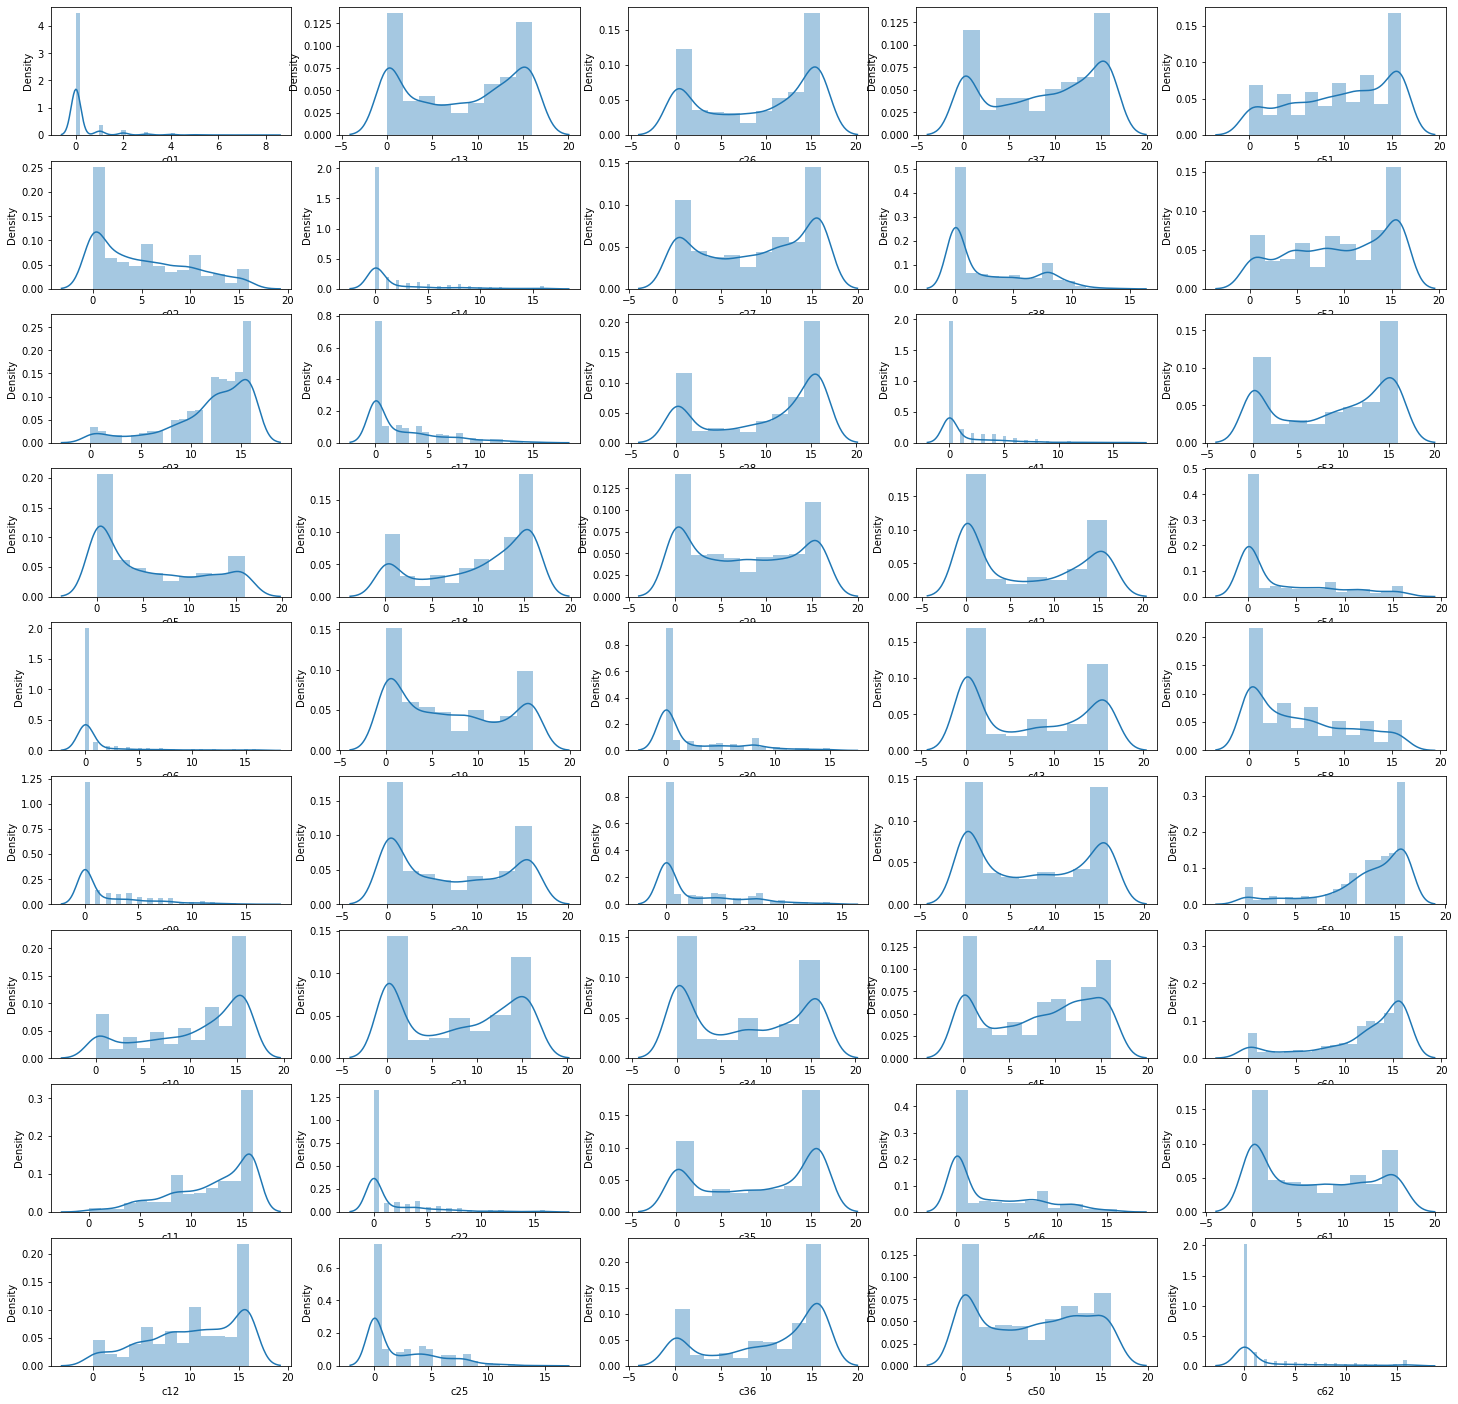

In [94]:
nx,ny = 9,5
columnas = atributos
i=0
fig, axs = plt.subplots(nx, ny, figsize=(25, 25))
for y in range(ny):
    for x in range(nx):
        sns.distplot(digitos_filtrados[columnas[i]], hist=True, rug=False, ax=axs[x,y],label = columnas[i])
        i+=1

Podemos notar que es un buen criterio seleccionar variables que estadisticamente no tienen relevancia debido a su sesgo a valer 0, esto se puede concluir pues los gráficos nos muestran que pocas de estas variables fueron incluidas en las elegidas, además podemos notar que se reducen nuestros datos de 64 columnas en x a 45 columnas. Estudiemos que tan rápido se ejecuta SVC con este nuevo frame

In [143]:
X = digitos_filtrados
y = y_training
X_train, X_test, Y_train, Y_test = train_test_split(X , y, test_size=0.2, random_state = 2)

model = SVC(kernel = "rbf", C = 5)
tiempo_inicial = time()

model.fit(X_train,Y_train)

tiempo_final = time()
tiempo_de_ejecucion = tiempo_final - tiempo_inicial
print("Tiempo de ejecución: ",tiempo_de_ejecucion)
y_pred = model.predict(X_test)
print(classification_report(Y_test,y_pred))



Tiempo de ejecución:  0.05289435386657715
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.96      1.00      0.98        44
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        36
           4       1.00      0.91      0.96        35
           5       0.98      0.98      0.98        43
           6       1.00      1.00      1.00        35
           7       1.00      1.00      1.00        40
           8       0.89      0.94      0.92        36
           9       0.96      0.93      0.95        28

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



Vemos que el modelo se sigue ajustando de buena forma y además es más rápido que el anterior cuando se consideran todos los atributos.

## 5.2. Extracción de atributos

En este caso aplicaremos PCA, dado que este algoritmo es sensible a la escala relativa de las variables originales realizaremos un escalamiento de los datos 

In [144]:
x = StandardScaler().fit_transform(x_training.values)

Ahora se procede a graficar con 45 componentes principales en PCA la varianza individual explicada por cada componente

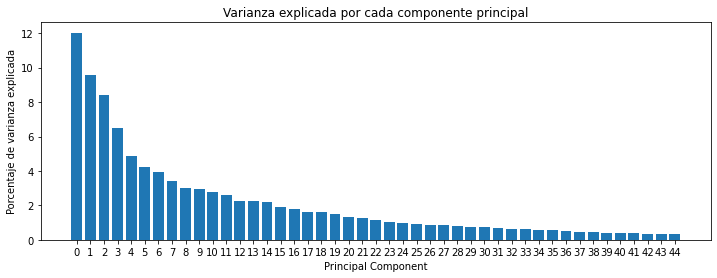

In [145]:
pca = PCA(n_components = 45)
principalComponents = pca.fit_transform(x)

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = list(range(0,45))

plt.figure(figsize=(12,4))
plt.bar(x= range(0,45), height=percent_variance, tick_label=columns)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Principal Component')
plt.title('Varianza explicada por cada componente principal')
plt.show()


Ahora graficamos la varianza acumulada

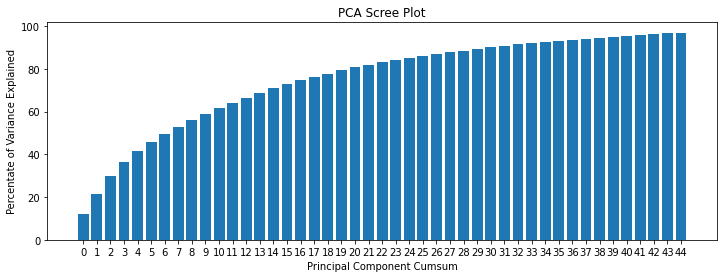

In [146]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)

plt.figure(figsize=(12,4))
plt.bar(x= range(0,45), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

Note que en la componente 21 (que en el gráfico es 20 debido a que contamos desde 0) se explica más del 80% de la varianza de los datos, por lo tanto analizaremos el tiempo de ejecución de SVM con PCA y además sus diferentes métricas, antes de esto veamos los gráficos de la distribución de probabilidad de cada componente

In [149]:
pca = PCA(n_components = 21)
principalComponents = pca.fit_transform(x)
principalDataframe = pd.DataFrame(data = principalComponents, columns = list(range(0,21)))
targetDataframe = digits[['target']]

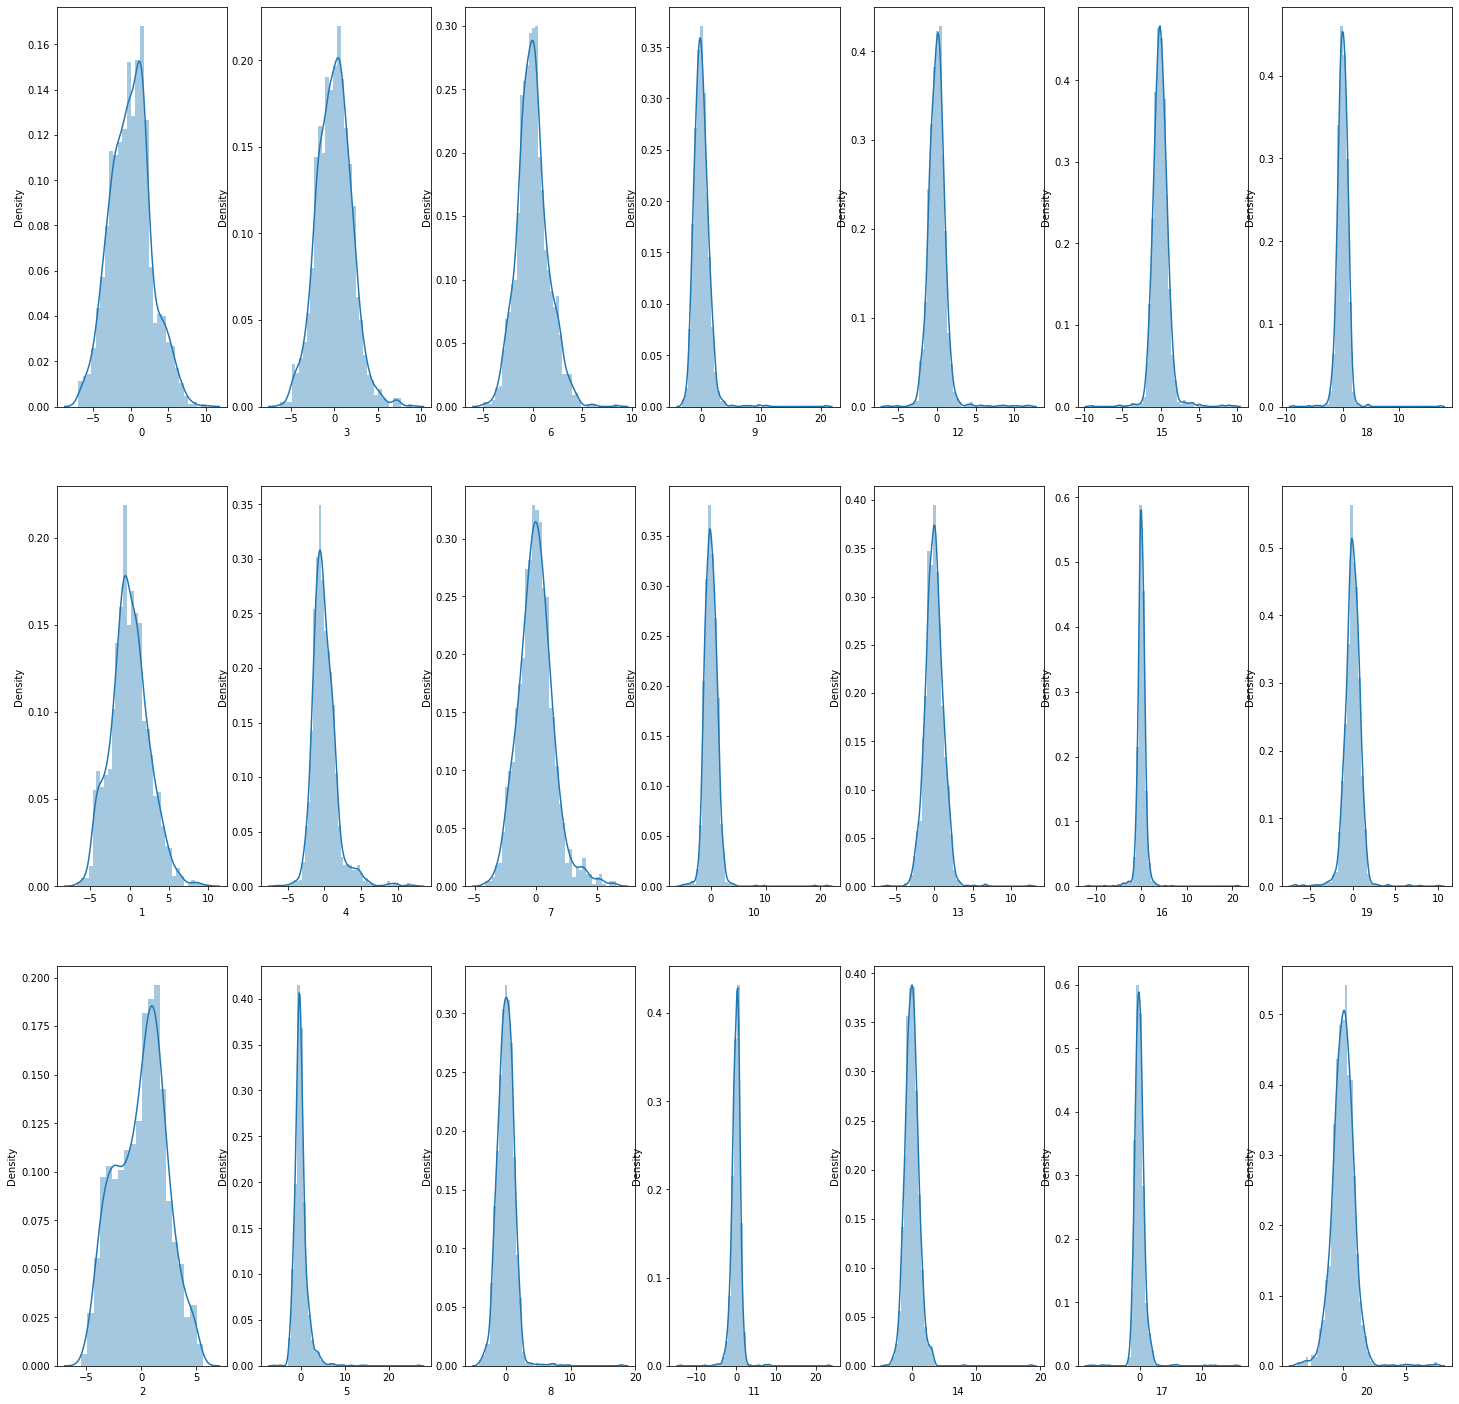

In [153]:
nx,ny = 3,7
columnas = list(range(0,21))
i=0
fig, axs = plt.subplots(nx, ny, figsize=(25, 25))
for y in range(ny):
    for x in range(nx):
        sns.distplot(principalDataframe[columnas[i]], hist=True, rug=False, ax=axs[x,y],label = columnas[i])
        i+=1

Vemos que algunas componentes tienden a preservar la normalidad que impusimos al escalar los datos y que poseen mayor varianza que los mostrados en un principio por los métodos de filtrado. Ahora veamos el rendimiento de SVM con PCA

In [151]:

X_train, X_test, Y_train, Y_test = train_test_split(principalDataframe , targetDataframe, test_size=0.2, random_state = 2)

model = SVC(kernel = "rbf", C = 5)
tiempo_inicial = time()

model.fit(X_train,Y_train)

tiempo_final = time()
tiempo_de_ejecucion = tiempo_final - tiempo_inicial
print("Tiempo de ejecución: ",tiempo_de_ejecucion)
y_pred = model.predict(X_test)
print(classification_report(Y_test,y_pred))


Tiempo de ejecución:  0.03590226173400879
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.96      1.00      0.98        44
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        36
           4       0.97      0.89      0.93        35
           5       1.00      0.98      0.99        43
           6       0.97      0.97      0.97        35
           7       0.95      1.00      0.98        40
           8       0.89      0.94      0.92        36
           9       0.92      0.86      0.89        28

    accuracy                           0.97       360
   macro avg       0.97      0.96      0.96       360
weighted avg       0.97      0.97      0.97       360



Vemos una leve disminución en precisión, recall y f1-score de la clase 4,6,9 en la clase 5,7 disminuyó la precisión y f1-score. A pesar de esto los resultados de macro average y weighted average son muy cercanos a 1 por lo que tenemos un buen clasificador con un tiempo de ejecución muy bajo.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [167]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = Y_test[mask]
    y_aux_pred = np.array(y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

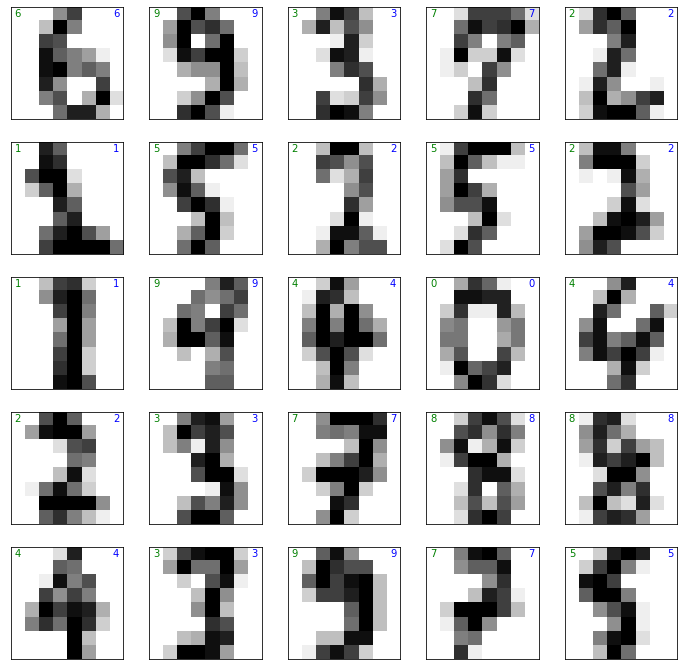

In [168]:
mostar_resultados(digits,SVC(kernel = "rbf", C=5),nx=5, ny=5,label = "correctos")

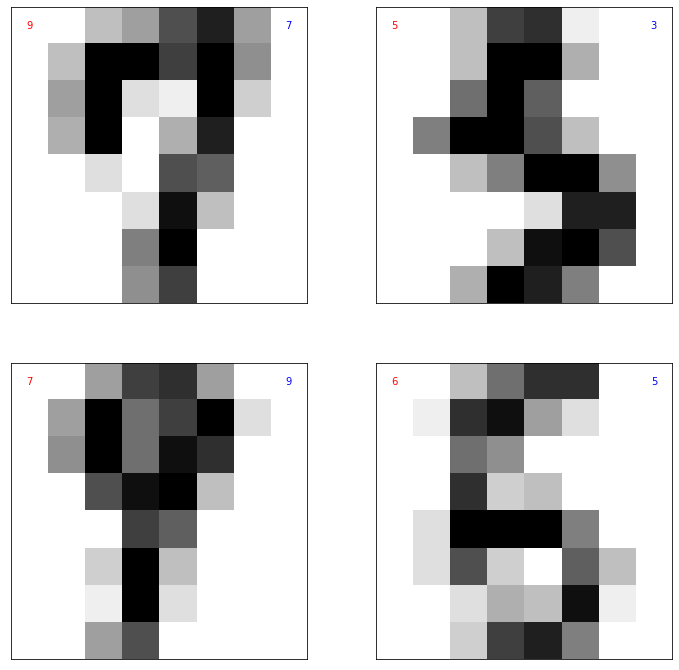

In [170]:
mostar_resultados(digits,SVC(kernel = "rbf", C=5),nx=2, ny=2,label = "incorrectos")

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

Estas fallas ocurren debido a que la etiqueta no es correcta y como estamos en un contexto de aprendizaje supervisado es importante basar el aprendizaje en las mismas.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

El modelo SVC tiene un ajuste muy preciso y con buenos resultados, reconoce de buena forma los patrones en los datos asociados a la forma de las imagenes lo cual con un seteo de hiperparámetros y reducción de dimensionalidad logran un tiempo de ejecución mucho menor a 1 segundo, algunas dificultades presentes son la etiqueta que contienen los datos, esto pues nuestro modelo arrojó errores que al analizar se puede notar que son errores de etiqueta lo cual es algo que no se puede controlar de manera tan fácil pero existen trabajos actuales donde se realiza un paso previo de procesamiento donde se validan datos (se hace mediante CNN lo cual escapa de los contenidos del curso y se puede ver acá https://dial.uclouvain.be/memoire/ucl/en/object/thesis%3A13006/datastream/PDF_01/view).

Desafíos futuros para este problema pueden ser:
* Entrenar con ruido para ver que tan robusto es el modelo y asi reconocer imagenes borrosas.
* Agregar más datos para ganar mayor capacidad de generalización, esto se puede hacer con data augmentation.